### Load Data

In [144]:
model_name = 'adl_model_siamese_baseline4_asapool'
num_epochs = 100

In [145]:
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader #To make use of this data loader, all graph attributes in the dataset need to have the same shape. In particular, this data loader should only be used when working with dense adjacency matrices.
from torch_geometric.nn import GCNConv, dense_diff_pool, ASAPooling
from torch_geometric.utils import dense_to_sparse
import math

In [146]:
data_dir_1 = 'C:/Users/david/pyproj/pyg/adl/patch_label_1'
data_dir_0 = 'C:/Users/david/pyproj/pyg/adl/patch_label_0'
#data_dir_1 = 'adl_data_1'
#data_dir_0 = 'adl_data_0'

In [147]:
from c_PatchDataset_sparse2 import PatchDataset
dataset = PatchDataset(data_dir_label_0 = data_dir_0,  data_dir_label_1=data_dir_1,  neg_pos_ratio=1)
len(dataset)

572

In [148]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs pairs: {len(dataset)}')

data1, data2 = dataset[0]  # Get the first graph object.
print(data1)
print(data2)

# Gather some statistics about the first graph.
print(f'Number of nodes in each: {data1.num_nodes}')
print(f'Number of node features: {data1.num_node_features}')


Dataset: PatchDataset(572):
Number of graphs pairs: 572
Data(x=[100, 3], edge_index=[2, 594], y=1)
Data(x=[100, 3], edge_index=[2, 584], y=1)
Number of nodes in each: 100
Number of node features: 3


In [149]:
graph_dataset= []
for data in dataset:
    graph_dataset.append(data[0])
    graph_dataset.append(data[1])
graph_dataset

[Data(x=[100, 3], edge_index=[2, 594], y=1),
 Data(x=[100, 3], edge_index=[2, 584], y=1),
 Data(x=[100, 3], edge_index=[2, 594], y=1),
 Data(x=[100, 3], edge_index=[2, 594], y=1),
 Data(x=[100, 3], edge_index=[2, 598], y=1),
 Data(x=[100, 3], edge_index=[2, 594], y=1),
 Data(x=[100, 3], edge_index=[2, 608], y=0),
 Data(x=[100, 3], edge_index=[2, 600], y=0),
 Data(x=[100, 3], edge_index=[2, 600], y=0),
 Data(x=[100, 3], edge_index=[2, 626], y=0),
 Data(x=[100, 3], edge_index=[2, 594], y=0),
 Data(x=[100, 3], edge_index=[2, 602], y=0),
 Data(x=[100, 3], edge_index=[2, 604], y=1),
 Data(x=[100, 3], edge_index=[2, 592], y=1),
 Data(x=[100, 3], edge_index=[2, 618], y=0),
 Data(x=[100, 3], edge_index=[2, 590], y=0),
 Data(x=[100, 3], edge_index=[2, 608], y=1),
 Data(x=[100, 3], edge_index=[2, 612], y=1),
 Data(x=[100, 3], edge_index=[2, 588], y=0),
 Data(x=[100, 3], edge_index=[2, 612], y=0),
 Data(x=[100, 3], edge_index=[2, 598], y=1),
 Data(x=[100, 3], edge_index=[2, 606], y=1),
 Data(x=[1

In [150]:
from torch_geometric.data import Data

pair_data = []
couple_loader = DataLoader(dataset = graph_dataset, batch_size=2, shuffle=False)

for couple in couple_loader:
    y = couple.y[0].long()
    couple_graph = Data(x=couple.x, edge_index=couple.edge_index, y=y, original_batch = couple.batch)
    pair_data.append(couple_graph)

In [151]:
pair_data[0]

Data(x=[200, 3], edge_index=[2, 1178], y=1, original_batch=[200])

In [152]:
batch_size = 10

n_train = math.ceil((4/6) * len(dataset))
n_val = math.ceil((len(dataset) - n_train)/2)
n_test = len(dataset) - n_train - n_val

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(pair_data, [n_train, n_val, n_test])
print(f'Number of training graphs pairs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

train_loader = DataLoader(dataset = train_dataset, batch_size= batch_size, shuffle=True)
val_loader = DataLoader(dataset = val_dataset, batch_size= batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size= batch_size, shuffle=True)

Number of training graphs pairs: 382
Number of validation graphs: 95
Number of test graphs: 95


In [153]:
databatch = next(iter(train_loader))
databatch

DataBatch(x=[2000, 3], edge_index=[2, 12146], y=[10], original_batch=[2000], batch=[2000], ptr=[11])

In [154]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x0, x1, y):

        diff = x0 - x1
        #print(f'Diff: {diff.shape}')

        pow = torch.pow(diff, 2)
        #print(f'Sq Diff: {pow.shape}')

        dist_sq = torch.sum(pow, 0)
        #print(f'Sum of Sq Diff: {dist_sq}')

        dist = torch.sqrt(dist_sq) 
        #print(f'Euclidean Dist: {dist}')

        mdist = self.margin - dist #negative euclidean distance - margin
        dist_marg = torch.clamp(mdist, min=0.0) # only distances <margin will be still positive here
        loss =  y * torch.pow(dist, 2) + (1-y) * torch.pow(dist_marg,2)
        #
        # dist = 0.2  label 1 --> 0.04
        # dist = 0.2  label 0 --> 0.64
        #
        # dist = 0.5  label 1 --> 0.25
        # dist = 0.5  label 0 --> 0.25
        # 
        # dist = 1.0  label 1 --> 1.0
        # dist = 1.0  label 0 --> 0
        #
        # dist = 1.5  label 1 --> 2.25
        # dist = 1.5  label 0 --> 0
        # 
        # dist = 3    label 1 --> 9
        # dist = 3    label 0 --> 0
        #


        loss = torch.sum(loss) / 2.0 / x0.size()[0]
        #print(f'Loss: {loss}')
        return loss

### Define Network

In [155]:
class GNN(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, pool_ratio, 
                 normalize=False, lin=False):
        super(GNN, self).__init__()

        self.conv1 = GCNConv(in_features, hidden_features, normalize)
        self.conv2 = GCNConv(hidden_features, out_features, normalize)
        self.pool = ASAPooling(out_features, ratio = pool_ratio)


    def forward(self, x, edge_index, batch=None):
        
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x, edge_index, _, batch, _ = self.pool(x, edge_index, batch=batch)

        return x, edge_index, batch


class ASAPool(torch.nn.Module):
    def __init__(self):
        super(ASAPool, self).__init__()

        self.gnn1 = GNN(dataset.num_features, 24, 24, pool_ratio=0.25)
        self.gnn2 = GNN(24, 32, 48, pool_ratio = 0.25)
        self.gnn3 = GNN(48, 72, 96, pool_ratio = 1)

        # Final Classifier
        #self.lin1 = torch.nn.Linear(96, 48) 
        #self.lin2 = torch.nn.Linear(48, 24)
        #self.lin3 = torch.nn.Linear(24, 2)




    def forward(self, x, edge_index, original_batch):

        #Hierarchical Step #1
        #print(x.shape, edge_index.shape, batch.shape)

        x, edge_index, batch = self.gnn1(x, edge_index, original_batch)
        #print(x.shape, edge_index.shape, batch.shape)
    
        # Hierarchical Step #2
        x, edge_index, batch = self.gnn2(x, edge_index, batch)
        #print(x.shape, edge_index.shape, batch.shape)

        # Hierarchical Step #3
        x, edge_index, batch = self.gnn3(x, edge_index, batch)
        #print(x.shape, edge_index.shape, batch.shape)

        # Final Classification
        #x = F.relu(self.lin1(x)) # Fully connected layer + relu
        #x = F.relu(self.lin2(x)) # Fully connected layer + relu
        #x = self.lin3(x) # Reduction to num_classes

        #log = F.log_softmax(x, dim=-1)
        
        return x #, l1 + l2 + l3, e1 + e2 + e3

In [156]:
def count_parameters(model, trainable=True):
    return sum(p.numel() for p in model.parameters() if p.requires_grad or not trainable)

In [157]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = ASAPool().to(device)
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(epoch):
    model.train()
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.original_batch)
        
        loss_contrastive = 0
        for j, i in enumerate(range(0, output.shape[0], 2)):
            loss = criterion(output[i], output[i+1], data.y[j])
            loss_contrastive += loss
        loss_contrastive = loss_contrastive/batch_size

        loss_contrastive.backward()
        loss_all += data.y.size(0) * loss_contrastive.item()
        optimizer.step()

    return loss_all# / len(train_dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    distances_lab1 = []
    distances_lab0 = []
    loss_all = 0
    

    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.original_batch)

        loss_contrastive = 0
        for j, i in enumerate(range(0, output.shape[0], 2)):
            loss = criterion(output[i], output[i+1], data.y[j])
            euclidean_distance = F.pairwise_distance(output[i], output[i+1])
            label = data.y[j]

            if int(label) == 1: 
                distances_lab1.append(float(euclidean_distance))
                loss_all += float(loss)
            else:
                distances_lab0.append(float(euclidean_distance))
                loss_all += float(loss)

    return  distances_lab0, distances_lab1, loss_all



train_distances_lab0 = []
train_distances_lab1 = []
train_losses = []

validation_distances_lab0 = []
validation_distances_lab1 = []
validation_losses = []

test_distances_lab0 = []
test_distances_lab1 = []
test_losses = []

for epoch in range(1, num_epochs+1):
    
    train_loss = train(epoch)

    train_results = test(train_loader)
    train_distances_lab0.append(train_results[0])
    train_distances_lab1.append(train_results[1])
    train_losses.append(train_results[2])


    validation_results = test(val_loader)
    validation_distances_lab0.append(validation_results[0])
    validation_distances_lab1.append(validation_results[1])
    validation_losses.append(validation_results[2])

    test_results = test(test_loader)
    test_distances_lab0.append(test_results[0])
    test_distances_lab1.append(test_results[1])
    test_losses.append(test_results[2])


    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.3f}, Train LR: {train_results[2]:.3f}, Val LR: {validation_results[2]:.3f}, Test LR: {test_results[2]:.3f}')
    #Train Acc: {train_acc:.3f}, f'Val Acc: {val_acc:.3f}, Test Acc: {test_acc:.3f}')
    


cpu
Epoch: 001, Train Loss: 0.513, Train LR: 0.511, Val LR: 0.114, Test LR: 0.106
Epoch: 002, Train Loss: 0.456, Train LR: 0.428, Val LR: 0.109, Test LR: 0.105
Epoch: 003, Train Loss: 0.434, Train LR: 0.475, Val LR: 0.131, Test LR: 0.123
Epoch: 004, Train Loss: 0.452, Train LR: 0.448, Val LR: 0.118, Test LR: 0.111
Epoch: 005, Train Loss: 0.446, Train LR: 0.418, Val LR: 0.109, Test LR: 0.103
Epoch: 006, Train Loss: 0.434, Train LR: 0.406, Val LR: 0.101, Test LR: 0.097
Epoch: 007, Train Loss: 0.426, Train LR: 0.434, Val LR: 0.111, Test LR: 0.103
Epoch: 008, Train Loss: 0.427, Train LR: 0.423, Val LR: 0.106, Test LR: 0.097
Epoch: 009, Train Loss: 0.432, Train LR: 0.428, Val LR: 0.099, Test LR: 0.101
Epoch: 010, Train Loss: 0.409, Train LR: 0.379, Val LR: 0.100, Test LR: 0.089
Epoch: 011, Train Loss: 0.414, Train LR: 0.386, Val LR: 0.106, Test LR: 0.093
Epoch: 012, Train Loss: 0.400, Train LR: 0.380, Val LR: 0.104, Test LR: 0.096
Epoch: 013, Train Loss: 0.392, Train LR: 0.377, Val LR: 0.09

In [180]:
import numpy as np
import matplotlib.pyplot as plt

def compare_euclid_distances(distances_lab0, distances_lab1):

    w = 0.8    # bar width
    x = [1, 2] # x-coordinates of your bars
    colors = [(0, 0, 1, 1), (1, 0, 0, 1)]    # corresponding colors

    # Epoch 0
    y = [distances_lab0, distances_lab1]


    fig, ax = plt.subplots()
    ax.bar(x,
        height=[np.mean(yi) for yi in y],
        yerr=[np.std(yi) for yi in y],    # error bars
        capsize=12, # error bar cap width in points
        width=w,    # bar width
        tick_label=["Label 0", "Label 1"],
        color=(0,0,0,0),  # face color transparent
        edgecolor=colors,
        )

    for i in range(len(x)):
        # distribute scatter randomly across whole width of bar
        ax.scatter(x[i] + np.random.random(len(y[i])) * w - w / 2, y[i], color=colors[i])

    plt.ylim(top=2, bottom=0)
    plt.show()


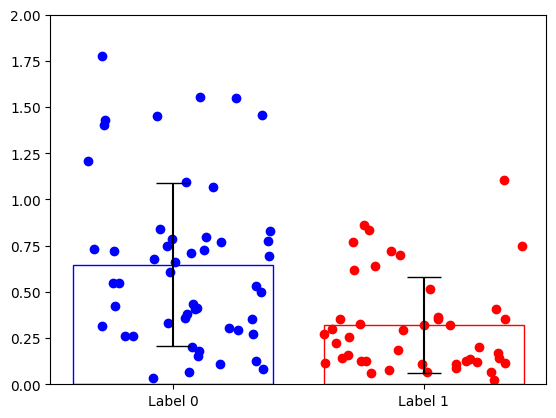

In [181]:
compare_euclid_distances(validation_distances_lab0[0], validation_distances_lab1[0])

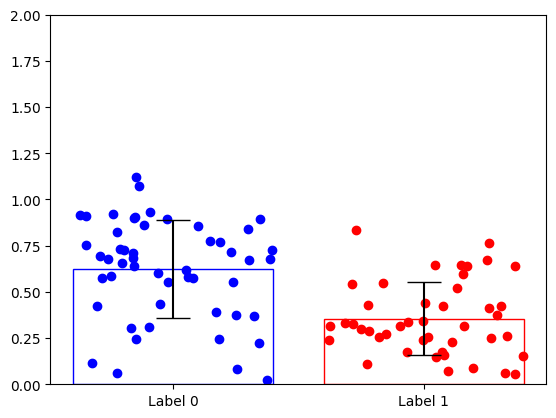

In [182]:
compare_euclid_distances(validation_distances_lab0[18], validation_distances_lab1[18])

In [179]:
test_distances_lab0[0]

[0.11790543794631958,
 0.27273038029670715,
 0.6148884296417236,
 0.5249922871589661,
 0.7452674508094788,
 0.21497668325901031,
 1.3533837795257568,
 0.2812080681324005,
 0.28153562545776367,
 1.2091134786605835,
 1.5194536447525024,
 1.0825098752975464,
 0.5332874059677124,
 1.6276143789291382,
 1.4966500997543335,
 0.7137364745140076,
 0.027139684185385704,
 0.25315791368484497,
 1.5292134284973145,
 0.7573800086975098,
 0.6040639281272888,
 0.6364903450012207,
 1.0205804109573364,
 0.5318518877029419,
 0.27408018708229065,
 0.33795875310897827,
 0.2105807662010193,
 0.13905030488967896,
 0.8119352459907532,
 0.13375210762023926,
 1.0861395597457886,
 0.9150688052177429,
 1.1109811067581177,
 0.7934256196022034,
 0.9549973011016846,
 0.17093776166439056,
 1.309762954711914,
 0.7299630641937256,
 0.16623233258724213,
 0.7909608483314514,
 0.7037020921707153,
 0.6715512871742249,
 1.1361606121063232,
 0.5778149962425232,
 0.07828478515148163,
 1.1033542156219482,
 0.5959640741348267,


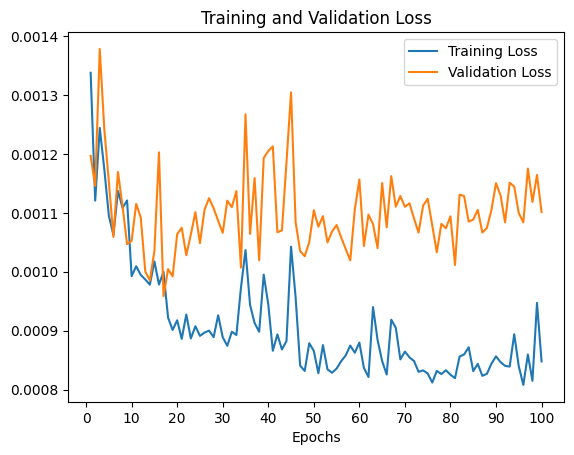

In [173]:
import matplotlib.pyplot as plt

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, num_epochs+1)
 
# Plot and label the training and validation loss values
plt.plot(epochs, [x/len(train_dataset) for x in train_losses], label='Training Loss')
plt.plot(epochs, [y/len(val_dataset) for y in validation_losses], label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
#plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(np.arange(0, num_epochs+1, num_epochs/10))
 
# Display the plot
plt.legend(loc='best')
plt.savefig(f'{model_name}_Training and Validation Loss.png')
plt.show()

In [163]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
gnn1.conv1.bias 	 torch.Size([24])
gnn1.conv1.lin.weight 	 torch.Size([24, 3])
gnn1.conv2.bias 	 torch.Size([24])
gnn1.conv2.lin.weight 	 torch.Size([24, 24])
gnn1.pool.lin.weight 	 torch.Size([24, 24])
gnn1.pool.lin.bias 	 torch.Size([24])
gnn1.pool.att.weight 	 torch.Size([1, 48])
gnn1.pool.att.bias 	 torch.Size([1])
gnn1.pool.gnn_score.lin1.weight 	 torch.Size([1, 24])
gnn1.pool.gnn_score.lin1.bias 	 torch.Size([1])
gnn1.pool.gnn_score.lin2.weight 	 torch.Size([1, 24])
gnn1.pool.gnn_score.lin3.weight 	 torch.Size([1, 24])
gnn1.pool.gnn_score.lin3.bias 	 torch.Size([1])
gnn2.conv1.bias 	 torch.Size([32])
gnn2.conv1.lin.weight 	 torch.Size([32, 24])
gnn2.conv2.bias 	 torch.Size([48])
gnn2.conv2.lin.weight 	 torch.Size([48, 32])
gnn2.pool.lin.weight 	 torch.Size([48, 48])
gnn2.pool.lin.bias 	 torch.Size([48])
gnn2.pool.att.weight 	 torch.Size([1, 96])
gnn2.pool.att.bias 	 torch.Size([1])
gnn2.pool.gnn_score.lin1.weight 	 torch.Size([1, 48])
gnn2.pool.gnn_score.lin1.

In [164]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {0: {'step': tensor(3900.), 'exp_avg': tensor([ 1.7799e-05, -2.2074e-04, -5.9531e-06, -4.9455e-05, -1.1256e-04,
        -1.5108e-04, -8.8815e-05, -4.5236e-05, -5.4845e-05, -2.5388e-04,
        -1.2157e-04,  1.3290e-04, -9.9505e-05,  1.4867e-04, -1.0734e-04,
         1.8239e-04, -1.9156e-05, -5.3976e-05, -2.1226e-04,  9.2757e-05,
         1.7172e-04,  1.2733e-06, -1.5781e-05, -6.9833e-05]), 'exp_avg_sq': tensor([3.9211e-07, 2.7164e-07, 2.7398e-07, 4.6170e-07, 8.1164e-07, 3.9390e-07,
        5.1790e-07, 1.6862e-07, 5.1790e-07, 3.6987e-07, 1.3454e-07, 1.7851e-07,
        2.3031e-07, 1.2249e-07, 7.6389e-07, 1.1312e-07, 1.2961e-07, 6.8179e-07,
        6.7922e-07, 2.7947e-07, 4.3910e-07, 3.0875e-07, 5.5746e-07, 1.7928e-07])}, 1: {'step': tensor(3900.), 'exp_avg': tensor([[ 2.6188e-05,  1.0478e-06,  1.2201e-04],
        [-2.6965e-05,  3.8363e-07,  6.5706e-05],
        [-5.2294e-06,  3.7322e-06, -1.0681e-04],
        [ 1.5475e-05,  2.9219e-06,  1.6263e-04],
    

In [165]:
torch.save(model.state_dict(), f'{model_name}_state_dict.pt')

In [166]:
torch.save(model, model_name+'.pt')

In [167]:
import numpy as np
tr_results = np.asarray(train_results)
tr_results.shape

C:\Users\david\AppData\Local\Temp\ipykernel_10368\3520072505.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tr_results = np.asarray(train_results)


(3,)

In [168]:
tr_results[0].shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
import matplotlib.pyplot as plt
np.random.seed(123)

w = 0.8    # bar width
x = [1, 2] # x-coordinates of your bars
colors = [(0, 0, 1, 1), (1, 0, 0, 1)]    # corresponding colors
y = [np.random.random(30) * 2 + 5,       # data series
    np.random.random(10) * 3 + 8]

fig, ax = plt.subplots()
ax.bar(x,
       height=[np.mean(yi) for yi in y],
       yerr=[np.std(yi) for yi in y],    # error bars
       capsize=12, # error bar cap width in points
       width=w,    # bar width
       tick_label=["control", "test"],
       color=(0,0,0,0),  # face color transparent
       edgecolor=colors,
       #ecolor=colors,    # error bar colors; setting this raises an error for whatever reason.
       )

for i in range(len(x)):
    # distribute scatter randomly across whole width of bar
    ax.scatter(x[i] + np.random.random(y[i].size) * w - w / 2, y[i], color=colors[i])

plt.show()

In [ ]:
import numpy as np
np.save(f'{model_name}_training_loss.npy', tr_loss, allow_pickle=True)
np.save(f'{model_name}_training_accuracy.npy', tr_acc, allow_pickle=True)

np.save(f'{model_name}_validation_loss.npy', v_loss, allow_pickle=True)
np.save(f'{model_name}_validation_accuracy.npy', v_acc, allow_pickle=True)

np.save(f'{model_name}_test_loss.npy', tst_loss, allow_pickle=True)
np.save(f'{model_name}_test_accuracy.npy', tst_acc, allow_pickle=True)

In [ ]:
import numpy as np
training_loss = np.load(f'{model_name}_training_loss.npy', allow_pickle=True)
training_accuracy = np.load(f'{model_name}_training_accuracy.npy', allow_pickle=True)

validation_loss = np.load(f'{model_name}_validation_loss.npy', allow_pickle=True)
validation_accuracy = np.load(f'{model_name}_validation_accuracy.npy', allow_pickle=True)

test_loss = np.load(f'{model_name}_test_loss.npy', allow_pickle=True)
test_accuracy = np.load(f'{model_name}_test_accuracy.npy', allow_pickle=True)

In [ ]:
import matplotlib.pyplot as plt

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, num_epochs+1)
 
# Plot and label the training and validation loss values
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(np.arange(0, num_epochs+1, num_epochs/10))
 
# Display the plot
plt.legend(loc='best')
plt.savefig(f'{model_name}_Training and Validation Loss.png')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, num_epochs+1)
 
# Plot and label the training and validation loss values
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.plot(epochs, test_accuracy, label='Test Accuracy')
 
# Add in a title and axes labels
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
 
# Set the tick locations
plt.xticks(np.arange(0, num_epochs+1, num_epochs/10))
plt.ylim(0,1)
 
# Display the plot
plt.legend(loc='best')
plt.savefig(f'{model_name}_Accuracy vs. Epochs.png')
plt.show()

In [ ]:
dataset_fraction = [0,0]

train_fraction = [0,0]
val_fraction = [0,0]
test_fraction = [0,0]

for grph in train_dataset: 
    if grph.y == 1: 
        train_fraction[1] +=1
        dataset_fraction[1] +=1 
    else: 
        train_fraction[0] +=1
        dataset_fraction[0] +=1 

for grph in val_dataset: 
    if grph.y == 1:
         val_fraction[1] +=1
         dataset_fraction[1] +=1  
    else:
         val_fraction[0] +=1
         dataset_fraction[0] +=1

for grph in test_dataset: 
    if grph.y == 1:
         test_fraction[1] +=1
         dataset_fraction[1] +=1 
    else:
         test_fraction[0] +=1
         dataset_fraction[0] +=1

print(f'Overall dataset percentage of label 1 = {dataset_fraction[1]/len(dataset)})')
print(f'Training dataset percentage of label 1 = {train_fraction} = {train_fraction[1]/len(train_dataset)}')
print(f'Validation dataset percentage of label 1 = {val_fraction} = {val_fraction[1]/len(val_dataset)}')
print(f'Test dataset percentage of label 1 = {test_fraction} = {test_fraction[1]/len(test_dataset)}')